<a href="https://colab.research.google.com/github/TobiasGustavo/Python/blob/main/Datasets_Folr_Panda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from pandas.io.clipboard import ENCODING
datasetsFolador = pd.read_csv('/content/drive/MyDrive/Datasets Research/dataset_0.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datasetsFolador.sample(10000)

In [ ]:
print(datasetsFolador.columns.to_list())

In [ ]:
datasetsFolador.dtypes

time\tpressure\trate    object
dtype: object

In [ ]:
datasetsFolador=datasetsFolador.dropna()

In [ ]:
datasetsFolador.head()

,time\tpressure\trate
0,0.2\t351.571\t559.975
1,0.201\t350.970\t559.975
2,0.202\t350.567\t559.975
3,0.203\t350.136\t559.975
4,0.204\t349.777\t559.975


In [ ]:
datasetsFolador.columns.values

array(['time\tpressure\trate'], dtype=object)

In [ ]:
colunasSelecionadas = ['time\tpressure\trate']

In [ ]:
datasetsFolador = datasetsFolador.filter(items=colunasSelecionadas)

In [ ]:
datasetsFolador.head()

,time\tpressure\trate
0,0.2\t351.571\t559.975
1,0.201\t350.970\t559.975
2,0.202\t350.567\t559.975
3,0.203\t350.136\t559.975
4,0.204\t349.777\t559.975


In [ ]:
datasetsFolador.plot()

TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt


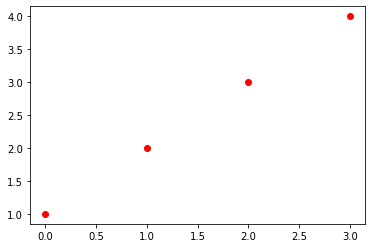

In [ ]:
plt.plot([1,2,3,4], "ro")
plt.show()

Text(0.5, 1.0, 'Caixa 3')

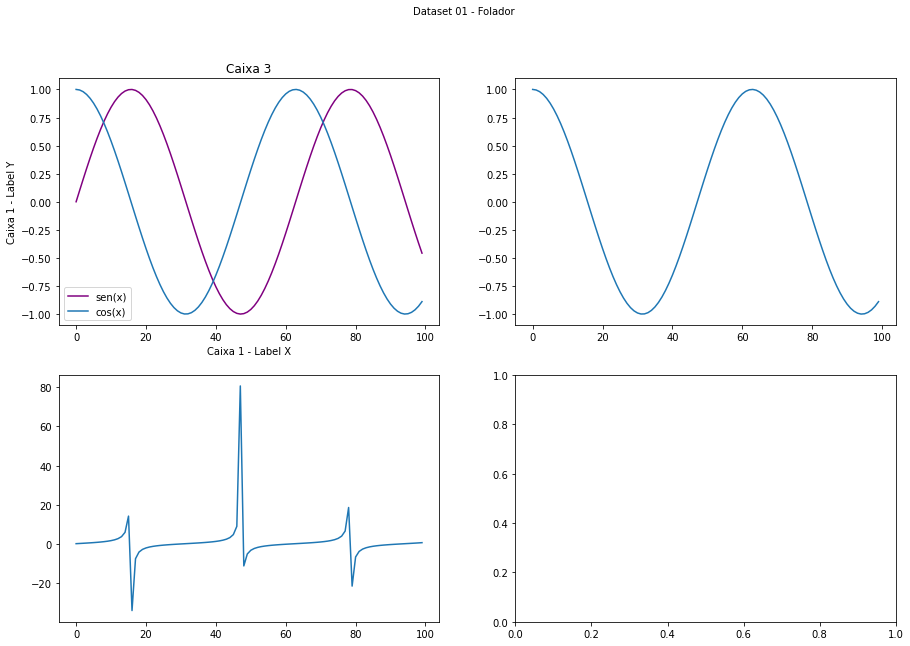

In [ ]:
from IPython.core.pylabtools import figsize
import numpy as np
x = np.arange(0,10, 0.1)
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
fig1.suptitle("Dataset 01 - Folador", size=10)

f1_axes[0, 0].plot(np.sin(x), label="sen(x)", color="purple")
f1_axes[0, 0].plot(np.cos(x), label="cos(x)")
f1_axes[0, 0].set_title("Caixa 1")
f1_axes[0, 0].set_xlabel("Caixa 1 - Label X")
f1_axes[0, 0].set_ylabel("Caixa 1 - Label Y")
f1_axes[0, 0].legend()


f1_axes[0, 1].plot(np.cos(x))
f1_axes[0, 0].set_title("Caixa 2")

f1_axes[1, 0].plot(np.tan(x))
f1_axes[0, 0].set_title("Caixa 3")


In [ ]:
datasetsFolador.plot()

TypeError: ignored

In [ ]:
df.plot()

NameError: ignored

In [ ]:
datasetsFolador=datasetsFolador.astype(float)

ValueError: ignored

In [4]:
DataFrame["Column_name"] = DataFrame["Column_name"].str.replace("[\$\,\.]", "")

NameError: ignored

In [3]:
import numpy as np
import pandas as pd
from time import sleep
import numdifftools.nd_scipy as nd
#import numdifftools as nd

from typing import List, Callable, Optional, Tuple
from collections import namedtuple
from scipy.optimize import (minimize,
                            NonlinearConstraint,
                            differential_evolution,
                            Bounds,
                            shgo,
                            basinhopping,)
import matplotlib.pyplot as plt
from copy import copy
from sklearn.utils.extmath import cartesian as sklearn_cartesian


class BRBResult(
    namedtuple(
        "BRBResult",
        [
            "precedents",
            "precedents_belief_degrees",
            "consequents",
            "consequent_belief_degrees",
        ],
    )
):
    """Defines a named tuple to contain a result generated by a BRB model.

    """
    def __str__(self):
        precedents_distributions = []
        for i in range(len(self.precedents)):
            distribution = []
            distribution.append(
                [
                    (a, b)
                    for a, b in zip(
                        self.precedents[i], self.precedents_belief_degrees[0][i]
                    )
                ]
            )
            precedents_distributions.append(distribution[0])
        return str(precedents_distributions)


class Trainables(
    namedtuple(
        "Trainables",
        [
            "flat_trainables",
            "n_attributes",
            "n_precedents",
            "n_rules",
            "n_consequents",
        ],
    )
):
    """Defines a named tuple containing information on the parameters of a
    BRB-model in a flattened format. This format is useful with various
    optimization routines.

    """

    def __str__(self):
        bre_m, thetas, deltas, precedents = BRB._unflatten_parameters(self)
        bre_m_df = pd.DataFrame(
            data=bre_m,
            index=[f"A_{i+1}" for i in range(bre_m.shape[0])],
            columns=[f"D_{i+1}" for i in range(bre_m.shape[1])],
        )
        thetas_df = pd.DataFrame(
            data=thetas,
            index=[f"θ_{i+1}" for i in range(thetas.shape[0])],
            columns=["Rule weight"],
        )
        deltas_df = pd.DataFrame(
            data=deltas,
            index=[f"δ_{i+1}" for i in range(deltas.shape[0])],
            columns=[f"x_{i+1}" for i in range(deltas.shape[1])],
        )
        precedents_df = pd.DataFrame(
            data=precedents,
            index=[f"A_{i+1}j" for i in range(precedents.shape[0])],
            columns=[f"A_i{i+1}" for i in range(precedents.shape[1])],
        )
        string = (
            "Belief rule expression matrix:\n{}\nRule weights:\n{}\n"
            "Attribute weights:\n{}\nPrecedents:\n{}"
        ).format(
            bre_m_df.round(3).to_string(),
            thetas_df.round(3).to_string(),
            deltas_df.to_string(),
            precedents_df.round(3).to_string(),
        )
        return string


class Rule(
    namedtuple(
        "Rule",
        [
            "condition",
            "action",
        ]
        
)):
    """Specifies a rule with a condition and action.

    The condition is specified in terms of the precedential values. A condition
    is a list of indices with the index referring to a precedent's referential
    values. For example, if a rule base has two attributes x1 and x2 with the
    referential values a01, a01, a10, and a11, the condition [0, 1] means that
    'if x1 is a01 and x2 is a11 then action' The action itself is specified as
    a floating point number, which should result as the weighted sum of the
    combined belief degrees times the consequential reference values in a rule
    base.

    """
    pass


class BRB:
    """Constructs a trainable BRB model.

    Arguments:
        precedents (np.ndarray): 2D dimensional array with the ith row
        representing the referential values for the ith attribute in the input
        of the model. The referential values should be in a hierarchial order
        where the first element of each row is the smallest element of the row,
        and the last element the greatest.
        consequents (np.ndarray): 2D array of the possible values for the
        output of the model. Must contain only one row.
        rule_weights (np.ndarray, optional): 1D array with the ith element
        representing the initial invidual rule weight for the ith rule.
        attr_weights (np.ndarray, optional): 2D array with the jth column
        represent the initial invidual attribute weight in the kth (row) rule.
        bre_m (np.ndarray, optional): 2D array with the initial belief rule
        expressions.
        f (Callable, optional): A function representing the system to be
        modeled.  Can be just a mapping from x -> y. Used to construct an
        initial rule base.

    Attributes:
        precedents (np.ndarray): 2D dimensional array with the ith row
        representing the referential values for the ith attribute in the input
        of the model.
        consequents (np.ndarray): 1D array of the possible values for the
        output of the model.
        rule_weights (np.ndarray, optional): 1D array with the ith element
        representing the initial invidual rule weight for the ith rule.
        attr_weights (np.ndarray, optional): 2D array with the jth column
        represent the initial invidual attribute weight in the k (row) rule.
        bre_m (np.ndarray, optional): 2D array with the initial belief rule
        expressions.
        f (Callable, optional): A function representing the system to be
        modeled.  Can be just a mapping from x -> y. Used to construct an
        initial rule base.
        utility (Callable, optional): A function that maps each consequent
        to a utility.
        trained (bool): Indicastes whether the model has been trained.

    """

    def __init__(
        self,
        precedents: np.ndarray,
        consequents: np.ndarray,
        rule_weights: Optional[np.ndarray] = None,
        attr_weights: Optional[np.ndarray] = None,
        bre_m: Optional[np.ndarray] = None,
        f: Optional[Callable] = None,
        rules: Optional[List[Rule]] = None,
        utility: Optional[Callable] = lambda y: y,
    ):
        self.precedents = precedents
        self.consequents = consequents
        self.f = f
        self.utility = utility
        self.rules = rules

        if self.f is not None or self.rules is not None:
            # construct the initial rule base using the precedents, the consequents,
            # and the mapping f.
            self.thetas, self.deltas, self.bre_m = self.construct_inital_rule_base(
                self.precedents, self.consequents, rule_action_fun=self.f, rules=self.rules
            )
        else:
            print("Rule mapping must be specified!")
            exit()

        self.trained = False

    def __str__(self):
        trainables = self._flatten_parameters()
        return str(trainables)

    def predict(self, x: np.ndarray) -> BRBResult:
        """Predictt an outcome using the current parameters set in the
        BRB-model for an input.

        Arguments:
            x (np.ndarray): A 2D array with each row representing a sample, where
            the value of the jth attribute is on the jth column.

        Returns:
            BRBResult: A named tuple with the model's consequents, precedents, and the
            respective belief distributions.

        """
        return self._predict(
            x,
            self.precedents,
            self.consequents,
            self.thetas,
            self.deltas,
            self.bre_m,
        )

    def _predict(
        self,
        x: np.ndarray,
        precedents: np.ndarray,
        consequents: np.ndarray,
        thetas: np.ndarray,
        deltas: np.ndarray,
        bre_m: np.ndarray,
    ) -> BRBResult:
        """Like predict, but the parameters of the BRB-model can be given
        explicitly. Used in for training. See BRB.predict and the top level
        documentation for this class for further details.

        """
        alphas = self.belief_distribution(x, precedents)

        if self.rules is None:
            # no explicit rules, use the cartesian products as the conditions
            rule_conditions = self.cartesian_product(alphas)
            
        else:
            # explicit rules, use them
            idx = np.linspace(0, len(precedents), len(precedents), endpoint=False, dtype=int)
            rule_conditions_g = (alphas[:, idx, rule.condition] for rule in self.rules)
            # conds_1 = alphas[:, idx, [0, 0, 0]]
            # conds_2 = alphas[:, idx, [1, 1, 1]]

            # rule_conditions = np.stack((conds_1, conds_2), axis=1)
            # print(f"rule conditions: {rule_conditions}")
            rule_conditions = np.stack(tuple(rule_conditions_g), axis=1)

        # calculate weights and combined belief degreees
        ws = self.calculate_activation_weights(rule_conditions, thetas, deltas)
        betas = self.calculate_combined_belief_degrees(bre_m, ws)

        res = BRBResult(precedents, alphas, consequents, betas)

        return res

    def construct_inital_rule_base(
            self, precedents: np.ndarray, consequents: np.ndarray, rule_action_fun: Optional[Callable] = None, rules: List[Rule] = None,
    ) -> (np.ndarray, np.ndarray, np.ndarray):
        """Constructs the initial rule base using precedents and consequents,
        and a given mapping from input to expected output. See the top level
        documentation for this class for details on the attributes.

        Returns:
            (np.ndarray, np.ndarray, np.ndarray): The rule weights, the
            attibute weights in each rule, and the belief rule expression
            matrix.

        """
        if rules is None:
            # construct the rule base using the mapping and the cartesian
            # products of the precedent reference values.
            rule_conditions = self.cartesian_product(precedents)
            thetas = np.ones((len(np.squeeze(rule_conditions)), 1)) / len(np.squeeze(rule_conditions))
            bre_m = self.construct_initial_belief_rule_exp_matrix(
            rule_conditions, consequents, rule_action_fun
            )

        else:
            # use the explicit rules given
            thetas = np.ones((len(rules), 1)) / len(rules)
            # rule_conditions = np.atleast_3d([
            #     [rule.condition for rule in rules]
            # ])
            # rule_actions = np.atleast_2d([
            #     rule.action for rule in rules
            # ])
            bre_m = self.construct_initial_belief_rule_exp_matrix_from_rules(rules, consequents)

        deltas = np.array([1])            

        return thetas, deltas, bre_m

    def belief_distribution(self, x, hs):
        """For each sample x in xs, transform x into a belief
        distributions according to the referential values hs.

        Arguments:
            x (np.ndarray): A 2D array with each row representing a sample, where
            the value of the jth attribute is on the jth column.        
            hs (np.narray): A 2D array with the i:th row containing the
            referential values for the i:th element in the input variable.

        Returns:
            (np.ndarray): A 2D array with the i:th element containing the belief
            degrees for the i:th sample in the input samples.

        """
        hs_fwd = np.roll(hs, 1)
        hs_bck = np.roll(hs, -1)

        max1 = np.fmax(
            (hs_fwd - x[:, :, None])
            / (hs_fwd - hs),
            0
        )
        max1 = np.where((max1 >= 0), max1, 0)

        max2 = np.fmax(
            (x[:, :, None] - hs_bck)
            / (hs - hs_bck),
            0
        )
        max2 = np.where((max2 >= 0), max2, 0)

        min_term = np.fmin(max1, max2)
        res = np.where(min_term <= 1, min_term, 1)

        return res

    def cartesian_product(self, mat: np.ndarray) -> np.ndarray:
        """Takes the element wise cartesian product of the vectors contained in each
        of the elements in mat. The first dimension of mat represents a sample.

        Arguments:
            mat (np.ndarray): A 3D numpy arrays with each of the elements being matrices.
            The row of the matrices will be used to form the cartesian products.

        Returns:
            (np.ndarray): The cartesian products as a 3D array.

        """
        # Works for a single sample, a 2D array as well.
        if mat.ndim < 3:
            mat = np.expand_dims(mat, 0)

        # prods = np.array(list(map(sklearn_cartesian, mat)))
        prods = np.zeros(
            (mat.shape[0], mat.shape[2] ** mat.shape[1], mat.shape[1])
        )

        for i in range(len(mat)):
            n_referential_sets = len(mat[i])

            if n_referential_sets == 1:
                # if math has just one set of referential values, return it
                prod = mat[i][0].reshape((-1, 1))

            else:
                grid = np.array(np.meshgrid(*mat[i]))
                prod = grid.T.reshape(-1, n_referential_sets)

            prods[i] = prod

        return prods

    def calculate_activation_weights(
        self, alphas: np.ndarray, thetas: np.ndarray, deltas: np.ndarray
    ):
        """Calculate the rule activation weights

        Arguments:
            alphas (np.ndarray): 3D array with the referential values. The first
            dimension represents the sample. In the samples each row
            represents a rule with the ith element representing the invidual
            matching degree, i.e. the belief degree that the antecedent x_i is
            assessed to the A_i value in the kth rule.
            thetas (np.ndarray): A 2D array with the individual rule weights as the
            columns.
            deltas (np.ndarray): A 3D array with the first dimension representin the
            invidual attribute weights in different rules.

        Returns:
            (np.ndarray): A 2D array containing the rule activation weights for
            each sample.

        Note:
            An AND connective rule is assumed between rules.

        """
        # number of total rules
        n_dists = alphas.shape[0]
        n_rules = alphas.shape[1]

        # if the attribute weights are given just for the first rule, copy them
        # for each rule.
        if deltas.ndim == 1:
            deltas = np.tile(deltas, (n_dists, alphas.shape[-1]))
        elif deltas.ndim == 2:
            deltas = np.tile(deltas[:, None], (alphas.shape[0])).reshape(
                alphas.shape
            )

        # compute the normalized attribute weights (None just adds an extra
        # axis so that broadcasting works)
        normed_deltas = deltas / np.max(deltas, axis=0)
        # expand thetas to work with boradcasts
        thetas_3d = np.repeat(thetas[None, :, :], alphas.shape[0], axis=0)

        if normed_deltas.shape != alphas.shape:
            prod = np.prod(
                (alphas + 0j) ** normed_deltas[:, None, :], axis=2
            ).real
        else:
            prod = np.prod((alphas + 0j) ** normed_deltas, axis=2).real

        prod2 = thetas_3d * prod[:, :, None]
        ws = np.squeeze(prod2 / (np.sum(prod2, axis=1)[:, :, None] + 1e-9))

        return np.atleast_2d(ws)

    def construct_initial_belief_rule_exp_matrix(
        self, rule_conditions: np.ndarray, consequents: np.ndarray, fun: Callable
    ):
        """Calculate the initial belief rule degree matrix using a known mapping
        from input to output on the referential value set. Each row should
        represent the output of each rule, when only said rule is activated.

        Attributes:
            refs (np.ndarray): 2D dimensional array of referential values. The
            ith row represents the possible referential values the ith
            attribute can take.
            consequents (np.ndarray): 1D array with the possible referential
            values the output of the BRB model may take. The output is assumed
            to be a scalar.
            fun (Callable): A mapping from a vector of attributes to a single
            scalar value.

        Returns:
            (np.ndarray): A matrix with the ith row representing the ith rule's
            belief degrees.

        Note:
            Works only with scalar valued functions at the moment.

        """
        # ys = np.apply_along_axis(fun, 1, rules)
        ys = fun(rule_conditions)
        return np.squeeze(self.belief_distribution(ys[0], consequents))

    def construct_initial_belief_rule_exp_matrix_from_rules(
            self, rules: List[Rule], consequents: np.ndarray,
    ):
        rule_actions = np.atleast_2d([
            rule.action for rule in rules
        ])
        return np.squeeze(self.belief_distribution(rule_actions, consequents))

    def calculate_combined_belief_degrees(
        self, bre: np.ndarray, ws: np.ndarray
    ):
        """Calculate the combined belief degree of a BRB system defined by a belief
        rule expression matrix and rule activation weights.

        Attributes:
            bre (np.ndarray): A brelief rule expression matrix with the ith row
            representing the ith rule's belief degreees.
            ws (np.ndarray): A 2D array whose first dimentions represents the rules in
            a sample. In the sample the  ith element representing the ith rule's
            activation weight.

        Returns:
            (np.ndarray): A 2D array of the combined belief degrees computed for
            each sample.

        """
        # total number of rules in the BRB
        n = bre.shape[1]

        wb_sum = ws * np.sum(bre, axis=1)
        bre_3d = np.repeat(bre[None, :, :], ws.shape[0], axis=0)
        wb_prod = ws[:, :, None] * bre_3d

        prod_1 = np.prod(wb_prod + 1 - wb_sum[:, :, None], axis=1)
        prod_2 = np.prod(1 - wb_sum, axis=1)
        prod_3 = np.sum(prod_1, axis=1)
        prod_4 = (n - 1) * prod_2
        prod_5 = np.prod(1 - ws, axis=1)

        betas = (prod_1 - prod_2[:, None]) / (
            prod_3[:, None] - prod_4[:, None] - prod_5[:, None] + 1e-9
        )

        return betas

    def train(
            self, xs: np.ndarray, ys: np.ndarray, _trainables: Trainables, obj_args: Tuple = None,
            fix_endpoints: bool = True, use_de: bool = False
    ) -> Trainables:
        """Train the BRB using input-output pairs. And update the model's parameters.

        Arguments:
            xs (np.ndarray): 2D array of the inputs with the n:th row being one
            sample with the elements representing the attribute values of that
            sample.
            ys (np.ndarray): 1D array of scalars with the n:th element
            representing the expected output for the n:th input in xs.
            _trainables (Trainables): A named tuple used to construct the
            optimization problem to train the BRB-model. Functions as an
            initial guess for the optimizer as well. See the documentation.
            obj_args (Tuple): Additional arguments to be supplied to the objective function.
            fix_endpoints (bool, optional): Whether the first and last
            precedents for each attribute should be fixed. If False, these
            values will also be trained. Default: True.
            use_de (bool, Optional): If false, uses a local solver, like SLSQP. Otherwise
            use differential evolution.

        Returns:
            Tainables: A named tuple containg the trained variables in a
            flattened format that define a trained BRB-model. If the
            optimization is not successfull, return the initial guess.

        """
        print("Training model...")
        trainables = copy(_trainables)

        # construct bounds
        # belief degrees between 0 and 1
        bre_m_bounds = np.repeat(
            np.array([[0, 1]]),
            trainables.n_rules * trainables.n_consequents,
            axis=0,
        )

        # rule weight between 0 and 1
        theta_bounds = np.repeat(
            np.array([[0, 1]]), trainables.n_rules, axis=0
        )

        # attribute weights between 0 and 1
        delta_bounds = np.repeat(
            np.array([[0, 1]]),
            trainables.n_rules * trainables.n_attributes,
            axis=0,
        )
        # precedents are unbound
        precedent_bounds = np.repeat(
            np.array([[-np.inf, np.inf]]),
            trainables.n_attributes * trainables.n_precedents,
            axis=0,
        )

        all_bounds = np.concatenate(
            (bre_m_bounds, theta_bounds, delta_bounds, precedent_bounds)
        )

        # rule weights must sum to one
        n_rules = trainables.n_rules
        rules_start = trainables.n_rules * trainables.n_consequents

        con_rules = dict(
            type="eq",
            fun=lambda x, start, end: np.sum(
                x[rules_start : (rules_start + n_rules)]
            )
            - 1,
            args=[rules_start, n_rules],
        )

        # construct constraints
        # each row in the BRE matrix must sum to 1
        n_row = trainables.n_rules
        n_col = trainables.n_consequents
        cons_betas = []

        for row in range(n_row):
            con = dict(
                type="eq",
                fun=lambda x, row, n_col: sum(
                    x[row * n_col : (row + 1) * n_col]
                )
                - 1,
                args=[row, n_col],
            )
            cons_betas.append(con)

        # precedents must be hierarchial
        n_total_precedents = trainables.n_attributes * trainables.n_precedents
        precedents_start = (
            trainables.flat_trainables.shape[0] - n_total_precedents
        )
        precedents_end = trainables.flat_trainables.shape[0]
        cons_precedents = []

        precedent_diff = 0.1
        for j in range(
            precedents_start, precedents_end, trainables.n_precedents
        ):
            for i in range(j, j + trainables.n_precedents - 1):
                con = dict(
                    type="ineq",
                    fun=lambda x, i, v: x[i + 1] - x[i] - v,
                    args=[i, precedent_diff],
                )

                cons_precedents.append(con)

                if fix_endpoints:
                    if i == (j + trainables.n_precedents - 1) - 1:
                        con = dict(
                            type="eq",
                            fun=lambda x, i, limit: x[i + 1] - limit,
                            args=[i, _trainables.flat_trainables[i + 1]],
                        )
                        cons_precedents.append(con)

                    if i == j:
                        con = dict(
                            type="eq",
                            fun=lambda x, i, limit: x[i] - limit,
                            args=[i, _trainables.flat_trainables[i]],
                        )
                        cons_precedents.append(con)

        all_cons = [con_rules] + cons_betas + cons_precedents

        if use_de:
            # define constraints to be used in differential evolution
            eq_cons = [con for con in all_cons if con["type"]=="eq"]
            ineq_cons = [con for con in all_cons if con["type"]=="ineq"]
            
            eq_fs = []
            ineq_fs = []
            for con in eq_cons:
                def f(x, con=con):
                    return np.abs(con["fun"](x, *con["args"]))
                eq_fs.append(f)

            eq_limits_low = np.repeat(0, len(eq_cons))
            eq_limits_up = np.repeat(0.001, len(eq_cons))
            eq_limits_relaxed = np.stack((eq_limits_low, eq_limits_up)).T
            eq_limits_strict = np.zeros((len(eq_cons), 2))

            for con in ineq_cons:
                def f(x, con=con):
                    return con["fun"](x, *con["args"])

                ineq_fs.append(f)

            ineq_limits_low = np.repeat(0, len(ineq_cons))
            ineq_limits_up = np.repeat(np.inf, len(ineq_cons))
            ineq_limits = np.stack((ineq_limits_low, ineq_limits_up)).T

            nlc_limits_relaxed = np.vstack((eq_limits_relaxed, ineq_limits))

            def constr_f_all(x, eq_fs=eq_fs, ineq_fs=ineq_fs):
                eq_res = np.array([f(x) for f in eq_fs])
                ineq_res = np.array([f(x) for f in ineq_fs])
                res = np.hstack((eq_res, ineq_res))
                return res

            nlc_relaxed = NonlinearConstraint(constr_f_all,
                                              nlc_limits_relaxed[:, 0],
                                              nlc_limits_relaxed[:, 1],
                                              keep_feasible=True,
                                              jac="3-point")

            def constr_f_eq(x, eq_fs=eq_fs):
                eq_res = np.array([f(x) for f in eq_fs])
                return eq_res

            def constr_f_ineq(x, ineq_fs=ineq_fs):
                ineq_res = np.array([f(x) for f in ineq_fs])
                return ineq_res

            nlc_strict_eq = NonlinearConstraint(constr_f_eq,
                                                eq_limits_strict[:, 0],
                                                eq_limits_strict[:, 1],
                                                keep_feasible=True,
                                                jac="3-point")
            
            nlc_strict_ineq = NonlinearConstraint(constr_f_ineq,
                                                  ineq_limits_low,
                                                  ineq_limits_up,
                                                  keep_feasible=True,
                                                  jac="3-point")

            bounds_de = np.array(all_bounds)
            #bounds_de[bounds_de == np.inf] = 1
            #bounds_de[bounds_de == 0] = 1e-9
            #bounds_de[bounds_de == -np.inf] = 0
            bounds_de = Bounds(bounds_de[:, 0], bounds_de[:, 1], keep_feasible=True)

        # prepend obj_args with the trainables and the default arguments, or supplied ones if provided.
        if obj_args is None:
            obj_args = (trainables,) + (xs, ys)
        else:
            obj_args = (trainables,) + obj_args


        if not use_de:
            opt_res = minimize(
                self._objective,
                trainables.flat_trainables,
                args=obj_args,
                method="SLSQP",
                bounds=all_bounds,
                constraints=all_cons,
                options={
                    "ftol": 1e-7,
                    "disp": True,
                    "maxiter": 100000,
                },
                callback=lambda x, obj_args=obj_args: print(f"f(x)={self._objective(x, *obj_args)}"),
            )

        else:
            def callback(x, convergence):
                bounds = (bounds_de.lb <= x) & (bounds_de.ub >= x)
                if np.all(bounds):
                    constr = nlc_relaxed.fun(x)
                    if np.min(constr) >= 0:
                        res = self._objective(x, *obj_args)
                        if res < 0.01:
                            print(res)
                            return True

            #initial = np.repeat(trainables.flat_trainables[None, :],
                                #20, axis=0)
#
            #rand = np.random.uniform(-0.01, 0.01, size=initial.shape)
            #rand = trainables.flat_trainables + rand
            #rand[0] = trainables.flat_trainables
#
            #print(rand)
            #input()

            #def check(x):
                #constrs = np.apply_along_axis(nlc_relaxed.fun, 1, x)
                #return np.all(constrs >= 0, axis=1)
#
#
            #n_to_find = 100
            #feasibles = np.zeros((0, 252))
            #minimum = 1
            #while True:
                #trial = np.random.uniform(bounds_de.lb, bounds_de.ub, size=(1000, len(trainables.flat_trainables)))
                #mask = check(trial)
                #if not np.all(mask):
                    ##feasibles = np.append(feasibles, trial[mask], axis=0)
                    #feasibles = trial[mask]
                    #results = np.apply_along_axis(lambda x: self._objective(x, *obj_args), 1, feasibles)
                    #iter_best = results[np.argmin(results)]
                    #print(iter_best)
#
                    #if iter_best < minimum:
                        #best = feasibles[np.argmin(results)]
                        #break
#
            ## feasibles[-1] = trainables.flat_trainables
            #print(best)

            #de_res = differential_evolution(
                #self._objective,
                #bounds_de,
                #args=obj_args,
                #constraints=nlc_relaxed,
                ##popsize=1,
                #mutation=(0, 1.99),
                #recombination=0.95,
                #disp=True,
                #maxiter=10000,
                ##atol=10,
                ##tol=0,
                ##tol=0.001,
                ##atol=0,
                #strategy="best1exp",
                ##strategy="best2bin",
                ##init="latinhypercube",
                #init=feasibles,
                #polish=False,
                ## callback=callback,
                #seed=1,
            #)

            #de_res = shgo(
                #self._objective,
                #all_bounds,
                #args=obj_args,
                #constraints=all_cons,
                #callback=lambda x: print("hello"),
                #options={
                    #"disp": True,
                #}
            #)

            def callback(x, convergence=None):
                res = self._objective(x, *obj_args)
                print(f"f(x)={res}")

            def grad(x, *args):
                res = nd.Gradient(lambda y, *_, **__: self._objective(y, *args), method="central", bounds=(bounds_de.lb, bounds_de.ub), step=0.1)
                return res(x)

            opt_res = minimize(
                self._objective,
                trainables.flat_trainables,
                args=obj_args,
                method="SLSQP",
                bounds=bounds_de,
                constraints=(nlc_strict_eq, nlc_strict_ineq),
                # jac=grad,
                options={
                    "ftol": 1e-6,
                    "disp": True,
                    "maxiter": 100000,
                    # "eps": 1e-2,
                },
                callback=callback,
            )
                #callback=callback,
                #options={
                    #"ftol": 1e-6,
                    #"disp": True,
                    #"maxiter": 100000,
                    #"eps": 1e-6,
                #},
                ## callback=lambda _: print("."),
                #)
            #minimizer_args = {
                #"method": "SLSQP",
                #"args": obj_args,
                #"constraints": all_cons,
            #}
            #opt_res = basinhopping(
                #self._objective,
                #trainables.flat_trainables,
                #minimizer_kwargs=minimizer_args,
            #)
            #opt_res = shgo(
                #self._objective,
                #bounds_de,
                #args=obj_args,
                #constraints=(nlc_strict_eq, nlc_strict_ineq),
                #n=1,
                #callback=lambda x: print("hello"),
                #options={
                    #"disp": True,
                    #"maxfev": 10,
                    #"maxev": 10,
                    #"maxtime": 0.005,
                    #"f_min": 1e-6,
                #}
            #)

        if opt_res.success:
            print("Training successfull!")
            x = opt_res.x
            trainables.flat_trainables[:] = x

            # update parameters
            bre_m, thetas, deltas, precedents = BRB._unflatten_parameters(
                trainables
            )
            self.bre_m = bre_m
            self.thetas = thetas
            self.deltas = deltas
            self.precedents = precedents
            self.trained = True
            return trainables
        else:
            print("Training NOT success!")
            print(opt_res)
            return _trainables

    def _objective(
        self,
        flat_trainables: np.ndarray,
        trainables: Trainables,
        xs: np.ndarray,
        ys_bar: np.ndarray,
    ):
        """A helper function that works as the objective for the optimization routine.
        Computes the total loss of a model with intermediate training parameters generated during
        optimization.

        """
        trainables.flat_trainables[:] = flat_trainables
        (
            self._train_bre_m,
            self._train_thetas,
            self._train_deltas,
            self._train_precedents,
        ) = BRB._unflatten_parameters(trainables)

        ys = self._predict_train(xs)
        res = (1 / xs.shape[0]) * np.sum(
            ((ys_bar - ys.reshape(-1, 1)))**2
        )
        return (res)

    def _default_objective_fun(xs: np.ndarray, ys: np.ndarray):
        res = (1 / xs.shape[0]) * np.sum(
            ((ys_bar - ys.reshape(-1, 1)))**2
        )
        return (res)

    def _flatten_parameters(self) -> Trainables:
        """Flattens the parameters of the current BRB model so that they can be
        used in training. Created a namedtuple with the flattened parameters
        and relevant information to rebuild the original paramaeters when
        needed.

        """
        n_attributes = self.precedents.shape[0]
        n_precedents = self.precedents.shape[1]
        n_rules = self.thetas.shape[0]
        n_consequents = self.consequents.shape[1]

        flat_bre_m = self.bre_m.flatten()
        flat_rules = self.thetas.flatten()
        # TODO: if given, use those
        if self.deltas.shape != (n_rules, n_attributes):
            flat_attws = np.ones(n_rules * n_attributes)
        else:
            flat_attws = self.deltas.flatten()
        flat_prece = self.precedents.flatten()
        flat_trainables = np.concatenate(
            (flat_bre_m, flat_rules, flat_attws, flat_prece)
        )

        trainables = Trainables(
            flat_trainables, n_attributes, n_precedents, n_rules, n_consequents
        )

        return trainables

    def _unflatten_parameters(
        trainables: Trainables
    ) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
        """Unflatten an instance of Trainables and return the paramters
        defining a BRB-model.

        Arguments:
            trainables (Trainables): A named tuple with flattened parameters
            defining a BRB-model.

        Returns:
            (np.ndarray, np.ndarray, np.ndarray, np.ndarray): The belief rule
            expression matrix, the rule weights, the attribute weights in each
            rule and the precedents.

        """
        # running index
        idx = 0
        bre_m = np.reshape(
            trainables.flat_trainables[
                0 : (trainables.n_rules * trainables.n_consequents)
            ],
            (trainables.n_rules, trainables.n_consequents),
        )
        idx = trainables.n_rules * trainables.n_consequents

        thetas = np.reshape(
            trainables.flat_trainables[idx : (idx + trainables.n_rules)],
            (trainables.n_rules, 1),
        )
        idx += trainables.n_rules

        deltas = np.reshape(
            trainables.flat_trainables[
                idx : (idx + trainables.n_rules * trainables.n_attributes)
            ],
            (trainables.n_rules, trainables.n_attributes),
        )
        idx += trainables.n_rules * trainables.n_attributes

        precedents = np.reshape(
            trainables.flat_trainables[
                idx : (idx + trainables.n_attributes * trainables.n_precedents)
            ],
            (trainables.n_attributes, trainables.n_precedents),
        )
        idx += trainables.n_attributes * trainables.n_precedents

        return bre_m, thetas, deltas, precedents

    def _predict_train(self, x: np.ndarray) -> float:
        """Predicts outcomes during training

        Arguments:
            trainables (Trainables): A named tuple with flattened parameters
            defining a BRB-model.
            x (np.ndarray): Input to the BRB-model.

        Returns:
            (float): A prediction

        """
        res = self._predict(
            x,
            self._train_precedents,
            self.consequents,
            self._train_thetas,
            self._train_deltas,
            self._train_bre_m,
        )

        return np.sum(
            self.utility(self.consequents) * res.consequent_belief_degrees,
            axis=1,
        )


class BRBPref(BRB):
    """With a custom objective

    """
    def _objective(
        self,
        flat_trainables: np.ndarray,
        trainables: Trainables,
        nadir: np.ndarray,
        ideal: np.ndarray,
        refs: np.ndarray = None,
        ref_targets: np.ndarray = None,
        dm_choices = None,
        print_res=False,
    ):
        """A helper function that works as the objective for the optimization routine.
        Computes the total loss of a model with intermediate training parameters generated during
        optimization.

        """

        trainables.flat_trainables[:] = flat_trainables
        (
            self._train_bre_m,
            self._train_thetas,
            self._train_deltas,
            self._train_precedents,
        ) = BRB._unflatten_parameters(trainables)

        delta = 0.01
        dm_penalty = 0
        if dm_choices is not None:
            for choice in dm_choices:
                fst = self._predict_train(np.atleast_2d(choice[0]))[0]
                snd = self._predict_train(np.atleast_2d(choice[1]))[0]
                pref = choice[-1]

                if pref == 1:
                    if fst < snd:
                        dm_penalty += abs(fst - snd)

                elif pref == 2:
                    if fst > snd:
                        dm_penalty += abs(fst - snd)

                elif pref == 0:
                    if np.abs(fst - snd) > delta:
                        dm_penalty += abs(fst - snd)
                else:
                    print("Something went horribly wrong")
                    exit()

            dm_penalty /= len(dm_choices)

        #n_test = 6
        #xx = np.mgrid[0:1.1:0.2, 0:1.1:0.2, 0:1.1:0.2].reshape(3, -1).T
        #xx_split = np.array(np.split(xx, n_test*n_test))
        #monotonic_penalty = 0
#
        #for test_points in xx_split:
            #test_res = self._predict_train(test_points)
            #diff = np.diff(test_res)
            #count = np.count_nonzero(diff < 0)
            #monotonic_penalty += count

        # test if monotonically non-decreasing BRB model
        obj_dim = nadir.shape[1]
        n_single_dim = 6
        n_test_samples = n_single_dim**(obj_dim)
        #np.random.seed(1)
        #xs_a = np.random.uniform(1e-9, 1, size=(n_test_samples, nadir.shape[1]))
        #xs_b = np.random.uniform(1e-9, 1, size=(n_test_samples, nadir.shape[1]))

        a = np.linspace(1e-9, 1, n_single_dim, endpoint=True)
        b = np.linspace(1e-9 + a[1] - a[0], 1, n_single_dim, endpoint=False)
        xs_a = np.vstack(np.meshgrid(*np.repeat(a[None, :], obj_dim, axis=0))).reshape(obj_dim, -1).T
        xs_b = np.vstack(np.meshgrid(*np.repeat(b[None, :], obj_dim, axis=0))).reshape(obj_dim, -1).T

        lhs = np.all(xs_a <= xs_b, axis=1)
        res_a = self._predict_train(xs_a)
        res_b = self._predict_train(xs_b)
        rhs = res_a <= res_b

        # for all x_a in xs_a and x_b in xs_b: for all elements in x_a and x_b:
        # x_a <= x_b, then f(x_a) <= f(x_b) => f is monotonically non-decreasing
        material_impl = ~lhs | rhs

        monotonic_penalty = np.count_nonzero(~material_impl) / n_test_samples
        #if monotonic_penalty > 0:
            #monotonic_penalty = np.abs(1/np.log(monotonic_penalty))

        ref_penalty = 0
        if refs is not None:
            ref_diff = np.abs(self._predict_train(refs) - ref_targets)
            ref_penalty = np.sum(
                np.where(ref_diff <= delta,
                        0,
                        ref_diff
                )
            )
            ref_penalty /= refs.shape[1]
            #if ref_penalty > 0:
                #ref_penalty = np.abs(1/np.log(ref_penalty))

        ideal_penalty = (1 - self._predict_train(ideal))**2
        nadir_penalty = (self._predict_train(nadir))**2

        if print_res:
            print(f"ref_penalty: {ref_penalty} \n"
                f"ideal_penalty: {ideal_penalty} \n"
                f"nadir_penalty: {nadir_penalty} \n"
                f"monotonic_penalty: {monotonic_penalty} \n"
                f"dm_penalty: {dm_penalty}"
            )
        
        minime = (ref_penalty + ideal_penalty + nadir_penalty + monotonic_penalty + dm_penalty) / 5
        # minime = np.max([ref_penalty, monotonic_penalty, dm_penalty]) + ideal_penalty + nadir_penalty
        return minime

# Testing
def article2():
    def himmelblau(x):
        x = np.squeeze(x)
        res = (x[:, 0] ** 2 + x[:, 1] - 11) ** 2 + (
            x[:, 0] + x[:, 1] ** 2 - 7
        ) ** 2
        return res.reshape(1, -1, 1)

    def linspace2d(low, up, n):
        step_s = (up - low) / n
        return (
            np.mgrid[
                low[0] : up[0] + 0.1 : step_s[0],
                low[1] : up[1] + 0.1 : step_s[1],
            ]
            .reshape(2, -1)
            .T
        )

    refs = np.array([[-6, -4, -2, 0, 2, 4, 6], [-6, -4, -2, 0, 2, 4, 6]])
    consequents = np.array([[0, 200, 500, 1000, 2200]])

    # Construct an initial model
    brb = BRB(refs, consequents, f=himmelblau)

    # generate a random set of inputs and outputs
    low = np.array([-6, -6])
    up = np.array([6, 6])
    n = 4
    xs_train = linspace2d(low, up, n)
    ys_train = himmelblau(xs_train)

    # Real data to compare to
    xs = linspace2d(low, up, 14)
    ys = himmelblau(xs)

    # untrained data
    res = brb.predict(xs)
    ys_untrained = np.sum(
        res.consequents * res.consequent_belief_degrees, axis=1
    )

    # train the BRB
    res = brb.train(xs_train, ys_train, brb._flatten_parameters())
    print(res)
    print(brb)

    # trained data
    res = brb.predict(xs)
    ys_trained = np.sum(
        res.consequents * res.consequent_belief_degrees, axis=1
    )

    ys = np.squeeze(ys)
    plt.plot(np.linspace(0, len(ys), len(ys)), ys, label="function")
    plt.plot(np.linspace(0, len(ys), len(ys)), ys_untrained, label="Untrained")
    plt.plot(np.linspace(0, len(ys), len(ys)), ys_trained, label="Trained")
    plt.legend()
    plt.show()



def article1():
    # define the problem and limits for the input
    def f(x):
        return x * np.sin(x ** 2)

    low = 0
    up = 3

    # create training data
    np.random.seed(1)
    n_train = 1000
    xs_train = np.sort(np.random.uniform(low, up, (n_train, 1)))
    ys_train = f(xs_train)

    # create evaluation data
    n_eval = 1000
    xs = np.linspace(low, up, n_eval).reshape(-1, 1)
    ys = f(xs)

    # create a brb model with given referential values
    precedents = np.array([[0, 0.5, 1, 1.5, 2, 2.5, 3]])
    consequents = np.array([[-2.5, -1, 1, 2, 3]])

    # construct an initial BRB model
    brb = BRB(precedents, consequents, f=f)
    print("Before training")

    # untrained predictions on evaluation data
    res = brb.predict(xs)
    ys_untrained = np.sum(
        res.consequents * res.consequent_belief_degrees, axis=1
    )

    # train the model
    brb.train(xs_train, ys_train, brb._flatten_parameters(), use_de=True)

    print("After training")
    print(brb)

    res = brb.predict(xs)
    ys_trained = np.sum(
        res.consequents * res.consequent_belief_degrees, axis=1
    )

    plt.plot(xs, ys, label="f", ls="dotted")
    plt.plot(xs, ys_untrained, label="untrained", ls="--")
    plt.plot(xs, ys_trained, label="trained")
    plt.ylim((-3, 3))
    plt.legend()

    plt.show()


if __name__ == "__main__":
    article1()

ModuleNotFoundError: ignored

In [9]:
!pip install numdifftools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 3.4 MB/s 
     |████████████████████████████████| 189 kB 11.4 MB/s 
  Created wheel for algopy: filename=algopy-0.5.7-py3-none-any.whl size=107608 sha256=7dc75ce06590bd405be14db56219d2de2190099da293bb8f11085b21899a995a
  Stored in directory: /root/.cache/pip/wheels/a8/fd/06/21dc6aba9f680fdbde386c06b1a8a1cf3d9a5f6bd96e31dcd4
Successfully built algopy


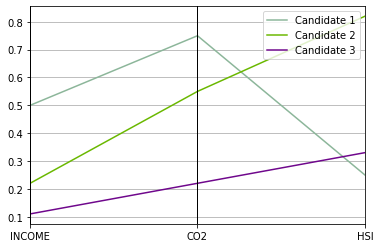

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from pandas.plotting import parallel_coordinates


candidates = np.array([[0.5, 0.75, 0.25],
                       [0.22, 0.55, 0.82],
                       [0.11, 0.22, 0.33]])
obj_names = ["INCOME", "CO2", "HSI"]

df = pandas.DataFrame(data=candidates,
                      index=[f"Candidate {i+1}" for i in range(len(candidates))],
                      columns=obj_names).reset_index()


parallel_coordinates(df, "index")
plt.show()
#data = np.zeros((candidates.shape[0], candidates.shape[1]+1))
#data[:, :-1] = candidates
#data[:, -1] = candidates[:, 0]
#print(data)
#
#n_vars = candidates.shape[1]
#
#angles = [n/n_vars*2*np.pi for n in range(n_vars)]
#angles += angles[:1]
#print(angles)
#
#ax = plt.subplot(111, polar=True)
#
#ax.set_theta_offset(np.pi / 2)
#ax.set_theta_direction(-1)
#
#plt.xticks(angles[:-1], obj_names)
#
#ax.set_rlabel_position(0)
#plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], color="grey", size=7)
#plt.ylim(0, 1)
#
#ax.plot(angles, data[0], linewidth=1, linestyle="solid", label="Candidate 1")
#ax.fill(angles, data[0], "b", alpha=0.1)
#ax.plot(angles, data[1], linewidth=1, linestyle="solid", label="Candidate 2")
#ax.fill(angles, data[1], "r", alpha=0.1)
#
#plt.show()

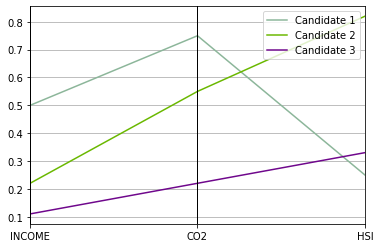

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from pandas.plotting import parallel_coordinates


candidates = np.array([[0.5, 0.75, 0.25],
                       [0.22, 0.55, 0.82],
                       [0.11, 0.22, 0.33]])
obj_names = ["INCOME", "CO2", "HSI"]

df = pandas.DataFrame(data=candidates,
                      index=[f"Candidate {i+1}" for i in range(len(candidates))],
                      columns=obj_names).reset_index()


parallel_coordinates(df, "index")
plt.show()

Before training
Training model...


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_constraints.py:331: OptimizeWarning: Constraint options `finite_diff_jac_sparsity`, `finite_diff_rel_step`, `keep_feasible`, and `hess`are ignored by this method.
  "are ignored by this method.", OptimizeWarning)


f(x)=0.5354023648999618
f(x)=1.5298658427521727
f(x)=1.7930387413547302
f(x)=0.11389753418349596
f(x)=0.11620449846934128
f(x)=0.05165469827509886
f(x)=0.02981666340055731
f(x)=0.022173783853340026
f(x)=0.02290300816668672
f(x)=0.027055988800813602
f(x)=0.02045649578891671
f(x)=0.02041635278914734
f(x)=0.020140478287218492
f(x)=0.020014317315407443
f(x)=0.019907069422921326
f(x)=0.01969662413772458
f(x)=0.01953325109339742
f(x)=0.019400599060037806
f(x)=0.019406245642361875
f(x)=0.01924538003036426
f(x)=0.019213918567870802
f(x)=0.01918396159483235
f(x)=0.01910406933920744
f(x)=0.018952518120790768
f(x)=0.018778149773679857
f(x)=0.018764770724897385
f(x)=0.018728865194560202
f(x)=0.018442378187141648
f(x)=0.01875843660512147
f(x)=0.01800359735198083
f(x)=0.017990689807862253
f(x)=0.017849469488267638
f(x)=0.017735802483436397
f(x)=0.01772019783297582
f(x)=0.017681873291334676
f(x)=0.0176706296363038
f(x)=0.01765760727082716
f(x)=0.017649456078124487
f(x)=0.017636525809522952
f(x)=0.017

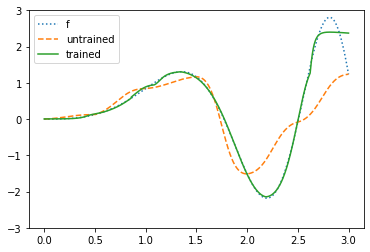

In [11]:
import numpy as np
import pandas as pd
from time import sleep
import numdifftools.nd_scipy as nd
#import numdifftools as nd

from typing import List, Callable, Optional, Tuple
from collections import namedtuple
from scipy.optimize import (minimize,
                            NonlinearConstraint,
                            differential_evolution,
                            Bounds,
                            shgo,
                            basinhopping,)
import matplotlib.pyplot as plt
from copy import copy
from sklearn.utils.extmath import cartesian as sklearn_cartesian


class BRBResult(
    namedtuple(
        "BRBResult",
        [
            "precedents",
            "precedents_belief_degrees",
            "consequents",
            "consequent_belief_degrees",
        ],
    )
):
    """Defines a named tuple to contain a result generated by a BRB model.

    """
    def __str__(self):
        precedents_distributions = []
        for i in range(len(self.precedents)):
            distribution = []
            distribution.append(
                [
                    (a, b)
                    for a, b in zip(
                        self.precedents[i], self.precedents_belief_degrees[0][i]
                    )
                ]
            )
            precedents_distributions.append(distribution[0])
        return str(precedents_distributions)


class Trainables(
    namedtuple(
        "Trainables",
        [
            "flat_trainables",
            "n_attributes",
            "n_precedents",
            "n_rules",
            "n_consequents",
        ],
    )
):
    """Defines a named tuple containing information on the parameters of a
    BRB-model in a flattened format. This format is useful with various
    optimization routines.

    """

    def __str__(self):
        bre_m, thetas, deltas, precedents = BRB._unflatten_parameters(self)
        bre_m_df = pd.DataFrame(
            data=bre_m,
            index=[f"A_{i+1}" for i in range(bre_m.shape[0])],
            columns=[f"D_{i+1}" for i in range(bre_m.shape[1])],
        )
        thetas_df = pd.DataFrame(
            data=thetas,
            index=[f"θ_{i+1}" for i in range(thetas.shape[0])],
            columns=["Rule weight"],
        )
        deltas_df = pd.DataFrame(
            data=deltas,
            index=[f"δ_{i+1}" for i in range(deltas.shape[0])],
            columns=[f"x_{i+1}" for i in range(deltas.shape[1])],
        )
        precedents_df = pd.DataFrame(
            data=precedents,
            index=[f"A_{i+1}j" for i in range(precedents.shape[0])],
            columns=[f"A_i{i+1}" for i in range(precedents.shape[1])],
        )
        string = (
            "Belief rule expression matrix:\n{}\nRule weights:\n{}\n"
            "Attribute weights:\n{}\nPrecedents:\n{}"
        ).format(
            bre_m_df.round(3).to_string(),
            thetas_df.round(3).to_string(),
            deltas_df.to_string(),
            precedents_df.round(3).to_string(),
        )
        return string


class Rule(
    namedtuple(
        "Rule",
        [
            "condition",
            "action",
        ]
        
)):
    """Specifies a rule with a condition and action.

    The condition is specified in terms of the precedential values. A condition
    is a list of indices with the index referring to a precedent's referential
    values. For example, if a rule base has two attributes x1 and x2 with the
    referential values a01, a01, a10, and a11, the condition [0, 1] means that
    'if x1 is a01 and x2 is a11 then action' The action itself is specified as
    a floating point number, which should result as the weighted sum of the
    combined belief degrees times the consequential reference values in a rule
    base.

    """
    pass


class BRB:
    """Constructs a trainable BRB model.

    Arguments:
        precedents (np.ndarray): 2D dimensional array with the ith row
        representing the referential values for the ith attribute in the input
        of the model. The referential values should be in a hierarchial order
        where the first element of each row is the smallest element of the row,
        and the last element the greatest.
        consequents (np.ndarray): 2D array of the possible values for the
        output of the model. Must contain only one row.
        rule_weights (np.ndarray, optional): 1D array with the ith element
        representing the initial invidual rule weight for the ith rule.
        attr_weights (np.ndarray, optional): 2D array with the jth column
        represent the initial invidual attribute weight in the kth (row) rule.
        bre_m (np.ndarray, optional): 2D array with the initial belief rule
        expressions.
        f (Callable, optional): A function representing the system to be
        modeled.  Can be just a mapping from x -> y. Used to construct an
        initial rule base.

    Attributes:
        precedents (np.ndarray): 2D dimensional array with the ith row
        representing the referential values for the ith attribute in the input
        of the model.
        consequents (np.ndarray): 1D array of the possible values for the
        output of the model.
        rule_weights (np.ndarray, optional): 1D array with the ith element
        representing the initial invidual rule weight for the ith rule.
        attr_weights (np.ndarray, optional): 2D array with the jth column
        represent the initial invidual attribute weight in the k (row) rule.
        bre_m (np.ndarray, optional): 2D array with the initial belief rule
        expressions.
        f (Callable, optional): A function representing the system to be
        modeled.  Can be just a mapping from x -> y. Used to construct an
        initial rule base.
        utility (Callable, optional): A function that maps each consequent
        to a utility.
        trained (bool): Indicastes whether the model has been trained.

    """

    def __init__(
        self,
        precedents: np.ndarray,
        consequents: np.ndarray,
        rule_weights: Optional[np.ndarray] = None,
        attr_weights: Optional[np.ndarray] = None,
        bre_m: Optional[np.ndarray] = None,
        f: Optional[Callable] = None,
        rules: Optional[List[Rule]] = None,
        utility: Optional[Callable] = lambda y: y,
    ):
        self.precedents = precedents
        self.consequents = consequents
        self.f = f
        self.utility = utility
        self.rules = rules

        if self.f is not None or self.rules is not None:
            # construct the initial rule base using the precedents, the consequents,
            # and the mapping f.
            self.thetas, self.deltas, self.bre_m = self.construct_inital_rule_base(
                self.precedents, self.consequents, rule_action_fun=self.f, rules=self.rules
            )
        else:
            print("Rule mapping must be specified!")
            exit()

        self.trained = False

    def __str__(self):
        trainables = self._flatten_parameters()
        return str(trainables)

    def predict(self, x: np.ndarray) -> BRBResult:
        """Predictt an outcome using the current parameters set in the
        BRB-model for an input.

        Arguments:
            x (np.ndarray): A 2D array with each row representing a sample, where
            the value of the jth attribute is on the jth column.

        Returns:
            BRBResult: A named tuple with the model's consequents, precedents, and the
            respective belief distributions.

        """
        return self._predict(
            x,
            self.precedents,
            self.consequents,
            self.thetas,
            self.deltas,
            self.bre_m,
        )

    def _predict(
        self,
        x: np.ndarray,
        precedents: np.ndarray,
        consequents: np.ndarray,
        thetas: np.ndarray,
        deltas: np.ndarray,
        bre_m: np.ndarray,
    ) -> BRBResult:
        """Like predict, but the parameters of the BRB-model can be given
        explicitly. Used in for training. See BRB.predict and the top level
        documentation for this class for further details.

        """
        alphas = self.belief_distribution(x, precedents)

        if self.rules is None:
            # no explicit rules, use the cartesian products as the conditions
            rule_conditions = self.cartesian_product(alphas)
            
        else:
            # explicit rules, use them
            idx = np.linspace(0, len(precedents), len(precedents), endpoint=False, dtype=int)
            rule_conditions_g = (alphas[:, idx, rule.condition] for rule in self.rules)
            # conds_1 = alphas[:, idx, [0, 0, 0]]
            # conds_2 = alphas[:, idx, [1, 1, 1]]

            # rule_conditions = np.stack((conds_1, conds_2), axis=1)
            # print(f"rule conditions: {rule_conditions}")
            rule_conditions = np.stack(tuple(rule_conditions_g), axis=1)

        # calculate weights and combined belief degreees
        ws = self.calculate_activation_weights(rule_conditions, thetas, deltas)
        betas = self.calculate_combined_belief_degrees(bre_m, ws)

        res = BRBResult(precedents, alphas, consequents, betas)

        return res

    def construct_inital_rule_base(
            self, precedents: np.ndarray, consequents: np.ndarray, rule_action_fun: Optional[Callable] = None, rules: List[Rule] = None,
    ) -> (np.ndarray, np.ndarray, np.ndarray):
        """Constructs the initial rule base using precedents and consequents,
        and a given mapping from input to expected output. See the top level
        documentation for this class for details on the attributes.

        Returns:
            (np.ndarray, np.ndarray, np.ndarray): The rule weights, the
            attibute weights in each rule, and the belief rule expression
            matrix.

        """
        if rules is None:
            # construct the rule base using the mapping and the cartesian
            # products of the precedent reference values.
            rule_conditions = self.cartesian_product(precedents)
            thetas = np.ones((len(np.squeeze(rule_conditions)), 1)) / len(np.squeeze(rule_conditions))
            bre_m = self.construct_initial_belief_rule_exp_matrix(
            rule_conditions, consequents, rule_action_fun
            )

        else:
            # use the explicit rules given
            thetas = np.ones((len(rules), 1)) / len(rules)
            # rule_conditions = np.atleast_3d([
            #     [rule.condition for rule in rules]
            # ])
            # rule_actions = np.atleast_2d([
            #     rule.action for rule in rules
            # ])
            bre_m = self.construct_initial_belief_rule_exp_matrix_from_rules(rules, consequents)

        deltas = np.array([1])            

        return thetas, deltas, bre_m

    def belief_distribution(self, x, hs):
        """For each sample x in xs, transform x into a belief
        distributions according to the referential values hs.

        Arguments:
            x (np.ndarray): A 2D array with each row representing a sample, where
            the value of the jth attribute is on the jth column.        
            hs (np.narray): A 2D array with the i:th row containing the
            referential values for the i:th element in the input variable.

        Returns:
            (np.ndarray): A 2D array with the i:th element containing the belief
            degrees for the i:th sample in the input samples.

        """
        hs_fwd = np.roll(hs, 1)
        hs_bck = np.roll(hs, -1)

        max1 = np.fmax(
            (hs_fwd - x[:, :, None])
            / (hs_fwd - hs),
            0
        )
        max1 = np.where((max1 >= 0), max1, 0)

        max2 = np.fmax(
            (x[:, :, None] - hs_bck)
            / (hs - hs_bck),
            0
        )
        max2 = np.where((max2 >= 0), max2, 0)

        min_term = np.fmin(max1, max2)
        res = np.where(min_term <= 1, min_term, 1)

        return res

    def cartesian_product(self, mat: np.ndarray) -> np.ndarray:
        """Takes the element wise cartesian product of the vectors contained in each
        of the elements in mat. The first dimension of mat represents a sample.

        Arguments:
            mat (np.ndarray): A 3D numpy arrays with each of the elements being matrices.
            The row of the matrices will be used to form the cartesian products.

        Returns:
            (np.ndarray): The cartesian products as a 3D array.

        """
        # Works for a single sample, a 2D array as well.
        if mat.ndim < 3:
            mat = np.expand_dims(mat, 0)

        # prods = np.array(list(map(sklearn_cartesian, mat)))
        prods = np.zeros(
            (mat.shape[0], mat.shape[2] ** mat.shape[1], mat.shape[1])
        )

        for i in range(len(mat)):
            n_referential_sets = len(mat[i])

            if n_referential_sets == 1:
                # if math has just one set of referential values, return it
                prod = mat[i][0].reshape((-1, 1))

            else:
                grid = np.array(np.meshgrid(*mat[i]))
                prod = grid.T.reshape(-1, n_referential_sets)

            prods[i] = prod

        return prods

    def calculate_activation_weights(
        self, alphas: np.ndarray, thetas: np.ndarray, deltas: np.ndarray
    ):
        """Calculate the rule activation weights

        Arguments:
            alphas (np.ndarray): 3D array with the referential values. The first
            dimension represents the sample. In the samples each row
            represents a rule with the ith element representing the invidual
            matching degree, i.e. the belief degree that the antecedent x_i is
            assessed to the A_i value in the kth rule.
            thetas (np.ndarray): A 2D array with the individual rule weights as the
            columns.
            deltas (np.ndarray): A 3D array with the first dimension representin the
            invidual attribute weights in different rules.

        Returns:
            (np.ndarray): A 2D array containing the rule activation weights for
            each sample.

        Note:
            An AND connective rule is assumed between rules.

        """
        # number of total rules
        n_dists = alphas.shape[0]
        n_rules = alphas.shape[1]

        # if the attribute weights are given just for the first rule, copy them
        # for each rule.
        if deltas.ndim == 1:
            deltas = np.tile(deltas, (n_dists, alphas.shape[-1]))
        elif deltas.ndim == 2:
            deltas = np.tile(deltas[:, None], (alphas.shape[0])).reshape(
                alphas.shape
            )

        # compute the normalized attribute weights (None just adds an extra
        # axis so that broadcasting works)
        normed_deltas = deltas / np.max(deltas, axis=0)
        # expand thetas to work with boradcasts
        thetas_3d = np.repeat(thetas[None, :, :], alphas.shape[0], axis=0)

        if normed_deltas.shape != alphas.shape:
            prod = np.prod(
                (alphas + 0j) ** normed_deltas[:, None, :], axis=2
            ).real
        else:
            prod = np.prod((alphas + 0j) ** normed_deltas, axis=2).real

        prod2 = thetas_3d * prod[:, :, None]
        ws = np.squeeze(prod2 / (np.sum(prod2, axis=1)[:, :, None] + 1e-9))

        return np.atleast_2d(ws)

    def construct_initial_belief_rule_exp_matrix(
        self, rule_conditions: np.ndarray, consequents: np.ndarray, fun: Callable
    ):
        """Calculate the initial belief rule degree matrix using a known mapping
        from input to output on the referential value set. Each row should
        represent the output of each rule, when only said rule is activated.

        Attributes:
            refs (np.ndarray): 2D dimensional array of referential values. The
            ith row represents the possible referential values the ith
            attribute can take.
            consequents (np.ndarray): 1D array with the possible referential
            values the output of the BRB model may take. The output is assumed
            to be a scalar.
            fun (Callable): A mapping from a vector of attributes to a single
            scalar value.

        Returns:
            (np.ndarray): A matrix with the ith row representing the ith rule's
            belief degrees.

        Note:
            Works only with scalar valued functions at the moment.

        """
        # ys = np.apply_along_axis(fun, 1, rules)
        ys = fun(rule_conditions)
        return np.squeeze(self.belief_distribution(ys[0], consequents))

    def construct_initial_belief_rule_exp_matrix_from_rules(
            self, rules: List[Rule], consequents: np.ndarray,
    ):
        rule_actions = np.atleast_2d([
            rule.action for rule in rules
        ])
        return np.squeeze(self.belief_distribution(rule_actions, consequents))

    def calculate_combined_belief_degrees(
        self, bre: np.ndarray, ws: np.ndarray
    ):
        """Calculate the combined belief degree of a BRB system defined by a belief
        rule expression matrix and rule activation weights.

        Attributes:
            bre (np.ndarray): A brelief rule expression matrix with the ith row
            representing the ith rule's belief degreees.
            ws (np.ndarray): A 2D array whose first dimentions represents the rules in
            a sample. In the sample the  ith element representing the ith rule's
            activation weight.

        Returns:
            (np.ndarray): A 2D array of the combined belief degrees computed for
            each sample.

        """
        # total number of rules in the BRB
        n = bre.shape[1]

        wb_sum = ws * np.sum(bre, axis=1)
        bre_3d = np.repeat(bre[None, :, :], ws.shape[0], axis=0)
        wb_prod = ws[:, :, None] * bre_3d

        prod_1 = np.prod(wb_prod + 1 - wb_sum[:, :, None], axis=1)
        prod_2 = np.prod(1 - wb_sum, axis=1)
        prod_3 = np.sum(prod_1, axis=1)
        prod_4 = (n - 1) * prod_2
        prod_5 = np.prod(1 - ws, axis=1)

        betas = (prod_1 - prod_2[:, None]) / (
            prod_3[:, None] - prod_4[:, None] - prod_5[:, None] + 1e-9
        )

        return betas

    def train(
            self, xs: np.ndarray, ys: np.ndarray, _trainables: Trainables, obj_args: Tuple = None,
            fix_endpoints: bool = True, use_de: bool = False
    ) -> Trainables:
        """Train the BRB using input-output pairs. And update the model's parameters.

        Arguments:
            xs (np.ndarray): 2D array of the inputs with the n:th row being one
            sample with the elements representing the attribute values of that
            sample.
            ys (np.ndarray): 1D array of scalars with the n:th element
            representing the expected output for the n:th input in xs.
            _trainables (Trainables): A named tuple used to construct the
            optimization problem to train the BRB-model. Functions as an
            initial guess for the optimizer as well. See the documentation.
            obj_args (Tuple): Additional arguments to be supplied to the objective function.
            fix_endpoints (bool, optional): Whether the first and last
            precedents for each attribute should be fixed. If False, these
            values will also be trained. Default: True.
            use_de (bool, Optional): If false, uses a local solver, like SLSQP. Otherwise
            use differential evolution.

        Returns:
            Tainables: A named tuple containg the trained variables in a
            flattened format that define a trained BRB-model. If the
            optimization is not successfull, return the initial guess.

        """
        print("Training model...")
        trainables = copy(_trainables)

        # construct bounds
        # belief degrees between 0 and 1
        bre_m_bounds = np.repeat(
            np.array([[0, 1]]),
            trainables.n_rules * trainables.n_consequents,
            axis=0,
        )

        # rule weight between 0 and 1
        theta_bounds = np.repeat(
            np.array([[0, 1]]), trainables.n_rules, axis=0
        )

        # attribute weights between 0 and 1
        delta_bounds = np.repeat(
            np.array([[0, 1]]),
            trainables.n_rules * trainables.n_attributes,
            axis=0,
        )
        # precedents are unbound
        precedent_bounds = np.repeat(
            np.array([[-np.inf, np.inf]]),
            trainables.n_attributes * trainables.n_precedents,
            axis=0,
        )

        all_bounds = np.concatenate(
            (bre_m_bounds, theta_bounds, delta_bounds, precedent_bounds)
        )

        # rule weights must sum to one
        n_rules = trainables.n_rules
        rules_start = trainables.n_rules * trainables.n_consequents

        con_rules = dict(
            type="eq",
            fun=lambda x, start, end: np.sum(
                x[rules_start : (rules_start + n_rules)]
            )
            - 1,
            args=[rules_start, n_rules],
        )

        # construct constraints
        # each row in the BRE matrix must sum to 1
        n_row = trainables.n_rules
        n_col = trainables.n_consequents
        cons_betas = []

        for row in range(n_row):
            con = dict(
                type="eq",
                fun=lambda x, row, n_col: sum(
                    x[row * n_col : (row + 1) * n_col]
                )
                - 1,
                args=[row, n_col],
            )
            cons_betas.append(con)

        # precedents must be hierarchial
        n_total_precedents = trainables.n_attributes * trainables.n_precedents
        precedents_start = (
            trainables.flat_trainables.shape[0] - n_total_precedents
        )
        precedents_end = trainables.flat_trainables.shape[0]
        cons_precedents = []

        precedent_diff = 0.1
        for j in range(
            precedents_start, precedents_end, trainables.n_precedents
        ):
            for i in range(j, j + trainables.n_precedents - 1):
                con = dict(
                    type="ineq",
                    fun=lambda x, i, v: x[i + 1] - x[i] - v,
                    args=[i, precedent_diff],
                )

                cons_precedents.append(con)

                if fix_endpoints:
                    if i == (j + trainables.n_precedents - 1) - 1:
                        con = dict(
                            type="eq",
                            fun=lambda x, i, limit: x[i + 1] - limit,
                            args=[i, _trainables.flat_trainables[i + 1]],
                        )
                        cons_precedents.append(con)

                    if i == j:
                        con = dict(
                            type="eq",
                            fun=lambda x, i, limit: x[i] - limit,
                            args=[i, _trainables.flat_trainables[i]],
                        )
                        cons_precedents.append(con)

        all_cons = [con_rules] + cons_betas + cons_precedents

        if use_de:
            # define constraints to be used in differential evolution
            eq_cons = [con for con in all_cons if con["type"]=="eq"]
            ineq_cons = [con for con in all_cons if con["type"]=="ineq"]
            
            eq_fs = []
            ineq_fs = []
            for con in eq_cons:
                def f(x, con=con):
                    return np.abs(con["fun"](x, *con["args"]))
                eq_fs.append(f)

            eq_limits_low = np.repeat(0, len(eq_cons))
            eq_limits_up = np.repeat(0.001, len(eq_cons))
            eq_limits_relaxed = np.stack((eq_limits_low, eq_limits_up)).T
            eq_limits_strict = np.zeros((len(eq_cons), 2))

            for con in ineq_cons:
                def f(x, con=con):
                    return con["fun"](x, *con["args"])

                ineq_fs.append(f)

            ineq_limits_low = np.repeat(0, len(ineq_cons))
            ineq_limits_up = np.repeat(np.inf, len(ineq_cons))
            ineq_limits = np.stack((ineq_limits_low, ineq_limits_up)).T

            nlc_limits_relaxed = np.vstack((eq_limits_relaxed, ineq_limits))

            def constr_f_all(x, eq_fs=eq_fs, ineq_fs=ineq_fs):
                eq_res = np.array([f(x) for f in eq_fs])
                ineq_res = np.array([f(x) for f in ineq_fs])
                res = np.hstack((eq_res, ineq_res))
                return res

            nlc_relaxed = NonlinearConstraint(constr_f_all,
                                              nlc_limits_relaxed[:, 0],
                                              nlc_limits_relaxed[:, 1],
                                              keep_feasible=True,
                                              jac="3-point")

            def constr_f_eq(x, eq_fs=eq_fs):
                eq_res = np.array([f(x) for f in eq_fs])
                return eq_res

            def constr_f_ineq(x, ineq_fs=ineq_fs):
                ineq_res = np.array([f(x) for f in ineq_fs])
                return ineq_res

            nlc_strict_eq = NonlinearConstraint(constr_f_eq,
                                                eq_limits_strict[:, 0],
                                                eq_limits_strict[:, 1],
                                                keep_feasible=True,
                                                jac="3-point")
            
            nlc_strict_ineq = NonlinearConstraint(constr_f_ineq,
                                                  ineq_limits_low,
                                                  ineq_limits_up,
                                                  keep_feasible=True,
                                                  jac="3-point")

            bounds_de = np.array(all_bounds)
            #bounds_de[bounds_de == np.inf] = 1
            #bounds_de[bounds_de == 0] = 1e-9
            #bounds_de[bounds_de == -np.inf] = 0
            bounds_de = Bounds(bounds_de[:, 0], bounds_de[:, 1], keep_feasible=True)

        # prepend obj_args with the trainables and the default arguments, or supplied ones if provided.
        if obj_args is None:
            obj_args = (trainables,) + (xs, ys)
        else:
            obj_args = (trainables,) + obj_args


        if not use_de:
            opt_res = minimize(
                self._objective,
                trainables.flat_trainables,
                args=obj_args,
                method="SLSQP",
                bounds=all_bounds,
                constraints=all_cons,
                options={
                    "ftol": 1e-7,
                    "disp": True,
                    "maxiter": 100000,
                },
                callback=lambda x, obj_args=obj_args: print(f"f(x)={self._objective(x, *obj_args)}"),
            )

        else:
            def callback(x, convergence):
                bounds = (bounds_de.lb <= x) & (bounds_de.ub >= x)
                if np.all(bounds):
                    constr = nlc_relaxed.fun(x)
                    if np.min(constr) >= 0:
                        res = self._objective(x, *obj_args)
                        if res < 0.01:
                            print(res)
                            return True

            #initial = np.repeat(trainables.flat_trainables[None, :],
                                #20, axis=0)
#
            #rand = np.random.uniform(-0.01, 0.01, size=initial.shape)
            #rand = trainables.flat_trainables + rand
            #rand[0] = trainables.flat_trainables
#
            #print(rand)
            #input()

            #def check(x):
                #constrs = np.apply_along_axis(nlc_relaxed.fun, 1, x)
                #return np.all(constrs >= 0, axis=1)
#
#
            #n_to_find = 100
            #feasibles = np.zeros((0, 252))
            #minimum = 1
            #while True:
                #trial = np.random.uniform(bounds_de.lb, bounds_de.ub, size=(1000, len(trainables.flat_trainables)))
                #mask = check(trial)
                #if not np.all(mask):
                    ##feasibles = np.append(feasibles, trial[mask], axis=0)
                    #feasibles = trial[mask]
                    #results = np.apply_along_axis(lambda x: self._objective(x, *obj_args), 1, feasibles)
                    #iter_best = results[np.argmin(results)]
                    #print(iter_best)
#
                    #if iter_best < minimum:
                        #best = feasibles[np.argmin(results)]
                        #break
#
            ## feasibles[-1] = trainables.flat_trainables
            #print(best)

            #de_res = differential_evolution(
                #self._objective,
                #bounds_de,
                #args=obj_args,
                #constraints=nlc_relaxed,
                ##popsize=1,
                #mutation=(0, 1.99),
                #recombination=0.95,
                #disp=True,
                #maxiter=10000,
                ##atol=10,
                ##tol=0,
                ##tol=0.001,
                ##atol=0,
                #strategy="best1exp",
                ##strategy="best2bin",
                ##init="latinhypercube",
                #init=feasibles,
                #polish=False,
                ## callback=callback,
                #seed=1,
            #)

            #de_res = shgo(
                #self._objective,
                #all_bounds,
                #args=obj_args,
                #constraints=all_cons,
                #callback=lambda x: print("hello"),
                #options={
                    #"disp": True,
                #}
            #)

            def callback(x, convergence=None):
                res = self._objective(x, *obj_args)
                print(f"f(x)={res}")

            def grad(x, *args):
                res = nd.Gradient(lambda y, *_, **__: self._objective(y, *args), method="central", bounds=(bounds_de.lb, bounds_de.ub), step=0.1)
                return res(x)

            opt_res = minimize(
                self._objective,
                trainables.flat_trainables,
                args=obj_args,
                method="SLSQP",
                bounds=bounds_de,
                constraints=(nlc_strict_eq, nlc_strict_ineq),
                # jac=grad,
                options={
                    "ftol": 1e-6,
                    "disp": True,
                    "maxiter": 100000,
                    # "eps": 1e-2,
                },
                callback=callback,
            )
                #callback=callback,
                #options={
                    #"ftol": 1e-6,
                    #"disp": True,
                    #"maxiter": 100000,
                    #"eps": 1e-6,
                #},
                ## callback=lambda _: print("."),
                #)
            #minimizer_args = {
                #"method": "SLSQP",
                #"args": obj_args,
                #"constraints": all_cons,
            #}
            #opt_res = basinhopping(
                #self._objective,
                #trainables.flat_trainables,
                #minimizer_kwargs=minimizer_args,
            #)
            #opt_res = shgo(
                #self._objective,
                #bounds_de,
                #args=obj_args,
                #constraints=(nlc_strict_eq, nlc_strict_ineq),
                #n=1,
                #callback=lambda x: print("hello"),
                #options={
                    #"disp": True,
                    #"maxfev": 10,
                    #"maxev": 10,
                    #"maxtime": 0.005,
                    #"f_min": 1e-6,
                #}
            #)

        if opt_res.success:
            print("Training successfull!")
            x = opt_res.x
            trainables.flat_trainables[:] = x

            # update parameters
            bre_m, thetas, deltas, precedents = BRB._unflatten_parameters(
                trainables
            )
            self.bre_m = bre_m
            self.thetas = thetas
            self.deltas = deltas
            self.precedents = precedents
            self.trained = True
            return trainables
        else:
            print("Training NOT success!")
            print(opt_res)
            return _trainables

    def _objective(
        self,
        flat_trainables: np.ndarray,
        trainables: Trainables,
        xs: np.ndarray,
        ys_bar: np.ndarray,
    ):
        """A helper function that works as the objective for the optimization routine.
        Computes the total loss of a model with intermediate training parameters generated during
        optimization.

        """
        trainables.flat_trainables[:] = flat_trainables
        (
            self._train_bre_m,
            self._train_thetas,
            self._train_deltas,
            self._train_precedents,
        ) = BRB._unflatten_parameters(trainables)

        ys = self._predict_train(xs)
        res = (1 / xs.shape[0]) * np.sum(
            ((ys_bar - ys.reshape(-1, 1)))**2
        )
        return (res)

    def _default_objective_fun(xs: np.ndarray, ys: np.ndarray):
        res = (1 / xs.shape[0]) * np.sum(
            ((ys_bar - ys.reshape(-1, 1)))**2
        )
        return (res)

    def _flatten_parameters(self) -> Trainables:
        """Flattens the parameters of the current BRB model so that they can be
        used in training. Created a namedtuple with the flattened parameters
        and relevant information to rebuild the original paramaeters when
        needed.

        """
        n_attributes = self.precedents.shape[0]
        n_precedents = self.precedents.shape[1]
        n_rules = self.thetas.shape[0]
        n_consequents = self.consequents.shape[1]

        flat_bre_m = self.bre_m.flatten()
        flat_rules = self.thetas.flatten()
        # TODO: if given, use those
        if self.deltas.shape != (n_rules, n_attributes):
            flat_attws = np.ones(n_rules * n_attributes)
        else:
            flat_attws = self.deltas.flatten()
        flat_prece = self.precedents.flatten()
        flat_trainables = np.concatenate(
            (flat_bre_m, flat_rules, flat_attws, flat_prece)
        )

        trainables = Trainables(
            flat_trainables, n_attributes, n_precedents, n_rules, n_consequents
        )

        return trainables

    def _unflatten_parameters(
        trainables: Trainables
    ) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
        """Unflatten an instance of Trainables and return the paramters
        defining a BRB-model.

        Arguments:
            trainables (Trainables): A named tuple with flattened parameters
            defining a BRB-model.

        Returns:
            (np.ndarray, np.ndarray, np.ndarray, np.ndarray): The belief rule
            expression matrix, the rule weights, the attribute weights in each
            rule and the precedents.

        """
        # running index
        idx = 0
        bre_m = np.reshape(
            trainables.flat_trainables[
                0 : (trainables.n_rules * trainables.n_consequents)
            ],
            (trainables.n_rules, trainables.n_consequents),
        )
        idx = trainables.n_rules * trainables.n_consequents

        thetas = np.reshape(
            trainables.flat_trainables[idx : (idx + trainables.n_rules)],
            (trainables.n_rules, 1),
        )
        idx += trainables.n_rules

        deltas = np.reshape(
            trainables.flat_trainables[
                idx : (idx + trainables.n_rules * trainables.n_attributes)
            ],
            (trainables.n_rules, trainables.n_attributes),
        )
        idx += trainables.n_rules * trainables.n_attributes

        precedents = np.reshape(
            trainables.flat_trainables[
                idx : (idx + trainables.n_attributes * trainables.n_precedents)
            ],
            (trainables.n_attributes, trainables.n_precedents),
        )
        idx += trainables.n_attributes * trainables.n_precedents

        return bre_m, thetas, deltas, precedents

    def _predict_train(self, x: np.ndarray) -> float:
        """Predicts outcomes during training

        Arguments:
            trainables (Trainables): A named tuple with flattened parameters
            defining a BRB-model.
            x (np.ndarray): Input to the BRB-model.

        Returns:
            (float): A prediction

        """
        res = self._predict(
            x,
            self._train_precedents,
            self.consequents,
            self._train_thetas,
            self._train_deltas,
            self._train_bre_m,
        )

        return np.sum(
            self.utility(self.consequents) * res.consequent_belief_degrees,
            axis=1,
        )


class BRBPref(BRB):
    """With a custom objective

    """
    def _objective(
        self,
        flat_trainables: np.ndarray,
        trainables: Trainables,
        nadir: np.ndarray,
        ideal: np.ndarray,
        refs: np.ndarray = None,
        ref_targets: np.ndarray = None,
        dm_choices = None,
        print_res=False,
    ):
        """A helper function that works as the objective for the optimization routine.
        Computes the total loss of a model with intermediate training parameters generated during
        optimization.

        """

        trainables.flat_trainables[:] = flat_trainables
        (
            self._train_bre_m,
            self._train_thetas,
            self._train_deltas,
            self._train_precedents,
        ) = BRB._unflatten_parameters(trainables)

        delta = 0.01
        dm_penalty = 0
        if dm_choices is not None:
            for choice in dm_choices:
                fst = self._predict_train(np.atleast_2d(choice[0]))[0]
                snd = self._predict_train(np.atleast_2d(choice[1]))[0]
                pref = choice[-1]

                if pref == 1:
                    if fst < snd:
                        dm_penalty += abs(fst - snd)

                elif pref == 2:
                    if fst > snd:
                        dm_penalty += abs(fst - snd)

                elif pref == 0:
                    if np.abs(fst - snd) > delta:
                        dm_penalty += abs(fst - snd)
                else:
                    print("Something went horribly wrong")
                    exit()

            dm_penalty /= len(dm_choices)

        #n_test = 6
        #xx = np.mgrid[0:1.1:0.2, 0:1.1:0.2, 0:1.1:0.2].reshape(3, -1).T
        #xx_split = np.array(np.split(xx, n_test*n_test))
        #monotonic_penalty = 0
#
        #for test_points in xx_split:
            #test_res = self._predict_train(test_points)
            #diff = np.diff(test_res)
            #count = np.count_nonzero(diff < 0)
            #monotonic_penalty += count

        # test if monotonically non-decreasing BRB model
        obj_dim = nadir.shape[1]
        n_single_dim = 6
        n_test_samples = n_single_dim**(obj_dim)
        #np.random.seed(1)
        #xs_a = np.random.uniform(1e-9, 1, size=(n_test_samples, nadir.shape[1]))
        #xs_b = np.random.uniform(1e-9, 1, size=(n_test_samples, nadir.shape[1]))

        a = np.linspace(1e-9, 1, n_single_dim, endpoint=True)
        b = np.linspace(1e-9 + a[1] - a[0], 1, n_single_dim, endpoint=False)
        xs_a = np.vstack(np.meshgrid(*np.repeat(a[None, :], obj_dim, axis=0))).reshape(obj_dim, -1).T
        xs_b = np.vstack(np.meshgrid(*np.repeat(b[None, :], obj_dim, axis=0))).reshape(obj_dim, -1).T

        lhs = np.all(xs_a <= xs_b, axis=1)
        res_a = self._predict_train(xs_a)
        res_b = self._predict_train(xs_b)
        rhs = res_a <= res_b

        # for all x_a in xs_a and x_b in xs_b: for all elements in x_a and x_b:
        # x_a <= x_b, then f(x_a) <= f(x_b) => f is monotonically non-decreasing
        material_impl = ~lhs | rhs

        monotonic_penalty = np.count_nonzero(~material_impl) / n_test_samples
        #if monotonic_penalty > 0:
            #monotonic_penalty = np.abs(1/np.log(monotonic_penalty))

        ref_penalty = 0
        if refs is not None:
            ref_diff = np.abs(self._predict_train(refs) - ref_targets)
            ref_penalty = np.sum(
                np.where(ref_diff <= delta,
                        0,
                        ref_diff
                )
            )
            ref_penalty /= refs.shape[1]
            #if ref_penalty > 0:
                #ref_penalty = np.abs(1/np.log(ref_penalty))

        ideal_penalty = (1 - self._predict_train(ideal))**2
        nadir_penalty = (self._predict_train(nadir))**2

        if print_res:
            print(f"ref_penalty: {ref_penalty} \n"
                f"ideal_penalty: {ideal_penalty} \n"
                f"nadir_penalty: {nadir_penalty} \n"
                f"monotonic_penalty: {monotonic_penalty} \n"
                f"dm_penalty: {dm_penalty}"
            )
        
        minime = (ref_penalty + ideal_penalty + nadir_penalty + monotonic_penalty + dm_penalty) / 5
        # minime = np.max([ref_penalty, monotonic_penalty, dm_penalty]) + ideal_penalty + nadir_penalty
        return minime

# Testing
def article2():
    def himmelblau(x):
        x = np.squeeze(x)
        res = (x[:, 0] ** 2 + x[:, 1] - 11) ** 2 + (
            x[:, 0] + x[:, 1] ** 2 - 7
        ) ** 2
        return res.reshape(1, -1, 1)

    def linspace2d(low, up, n):
        step_s = (up - low) / n
        return (
            np.mgrid[
                low[0] : up[0] + 0.1 : step_s[0],
                low[1] : up[1] + 0.1 : step_s[1],
            ]
            .reshape(2, -1)
            .T
        )

    refs = np.array([[-6, -4, -2, 0, 2, 4, 6], [-6, -4, -2, 0, 2, 4, 6]])
    consequents = np.array([[0, 200, 500, 1000, 2200]])

    # Construct an initial model
    brb = BRB(refs, consequents, f=himmelblau)

    # generate a random set of inputs and outputs
    low = np.array([-6, -6])
    up = np.array([6, 6])
    n = 4
    xs_train = linspace2d(low, up, n)
    ys_train = himmelblau(xs_train)

    # Real data to compare to
    xs = linspace2d(low, up, 14)
    ys = himmelblau(xs)

    # untrained data
    res = brb.predict(xs)
    ys_untrained = np.sum(
        res.consequents * res.consequent_belief_degrees, axis=1
    )

    # train the BRB
    res = brb.train(xs_train, ys_train, brb._flatten_parameters())
    print(res)
    print(brb)

    # trained data
    res = brb.predict(xs)
    ys_trained = np.sum(
        res.consequents * res.consequent_belief_degrees, axis=1
    )

    ys = np.squeeze(ys)
    plt.plot(np.linspace(0, len(ys), len(ys)), ys, label="function")
    plt.plot(np.linspace(0, len(ys), len(ys)), ys_untrained, label="Untrained")
    plt.plot(np.linspace(0, len(ys), len(ys)), ys_trained, label="Trained")
    plt.legend()
    plt.show()



def article1():
    # define the problem and limits for the input
    def f(x):
        return x * np.sin(x ** 2)

    low = 0
    up = 3

    # create training data
    np.random.seed(1)
    n_train = 1000
    xs_train = np.sort(np.random.uniform(low, up, (n_train, 1)))
    ys_train = f(xs_train)

    # create evaluation data
    n_eval = 1000
    xs = np.linspace(low, up, n_eval).reshape(-1, 1)
    ys = f(xs)

    # create a brb model with given referential values
    precedents = np.array([[0, 0.5, 1, 1.5, 2, 2.5, 3]])
    consequents = np.array([[-2.5, -1, 1, 2, 3]])

    # construct an initial BRB model
    brb = BRB(precedents, consequents, f=f)
    print("Before training")

    # untrained predictions on evaluation data
    res = brb.predict(xs)
    ys_untrained = np.sum(
        res.consequents * res.consequent_belief_degrees, axis=1
    )

    # train the model
    brb.train(xs_train, ys_train, brb._flatten_parameters(), use_de=True)

    print("After training")
    print(brb)

    res = brb.predict(xs)
    ys_trained = np.sum(
        res.consequents * res.consequent_belief_degrees, axis=1
    )

    plt.plot(xs, ys, label="f", ls="dotted")
    plt.plot(xs, ys_untrained, label="untrained", ls="--")
    plt.plot(xs, ys_trained, label="trained")
    plt.ylim((-3, 3))
    plt.legend()

    plt.show()


if __name__ == "__main__":
    article1()